In [1]:
!pip install torch pandas transformers matplotlib


In [7]:
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt


Training EAM Intent Classifier
Epoch 1/50, Loss: 2.8530, Accuracy: 0.0144
Epoch 2/50, Loss: 2.5163, Accuracy: 0.0258
Epoch 3/50, Loss: 2.2655, Accuracy: 0.3302
Epoch 4/50, Loss: 2.0812, Accuracy: 0.4592
Epoch 5/50, Loss: 1.9580, Accuracy: 0.4582
Epoch 6/50, Loss: 1.8969, Accuracy: 0.4582
Epoch 7/50, Loss: 1.8623, Accuracy: 0.4582
Epoch 8/50, Loss: 1.8568, Accuracy: 0.4582
Epoch 9/50, Loss: 1.8323, Accuracy: 0.4582
Epoch 10/50, Loss: 1.8221, Accuracy: 0.4582
Epoch 11/50, Loss: 1.8216, Accuracy: 0.4582
Epoch 12/50, Loss: 1.8250, Accuracy: 0.4582
Epoch 13/50, Loss: 1.8128, Accuracy: 0.4582
Epoch 14/50, Loss: 1.8016, Accuracy: 0.4582
Epoch 15/50, Loss: 1.8002, Accuracy: 0.4582
Epoch 16/50, Loss: 1.8081, Accuracy: 0.4582
Epoch 17/50, Loss: 1.7906, Accuracy: 0.4582
Epoch 18/50, Loss: 1.7759, Accuracy: 0.4582
Epoch 19/50, Loss: 1.7815, Accuracy: 0.4582
Epoch 20/50, Loss: 1.7722, Accuracy: 0.4582
Epoch 21/50, Loss: 1.7623, Accuracy: 0.4582
Epoch 22/50, Loss: 1.7721, Accuracy: 0.4582
Epoch 23/5

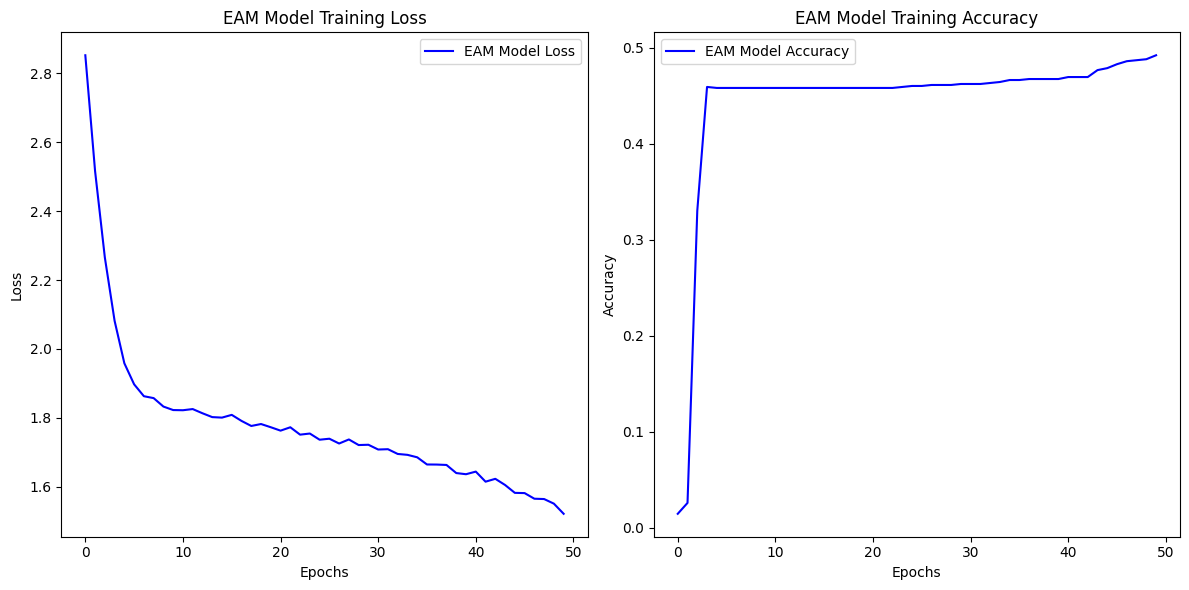

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Custom tokenizer function to split text into words
def custom_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Dataset preparation using the custom tokenizer
class CustomIntentDataset(Dataset):
    def __init__(self, df, vocab, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.vocab = vocab
        self.max_len = max_len

        # Map categories to numerical labels
        self.label_mapping = {label: idx for idx, label in enumerate(df['Category'].unique())}
        self.df['Category'] = self.df['Category'].map(self.label_mapping)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.df['Category'].iloc[idx]

        # Tokenize text
        tokens = custom_tokenizer(text)
        token_ids = [self.vocab.get(token, 0) for token in tokens]

        # Apply padding or truncation
        if len(token_ids) < self.max_len:
            token_ids = token_ids + [self.vocab['<PAD>']] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Token pooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Training function
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in dataloader:
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, all_accuracies

# Load dataset
df = pd.read_csv("/content/PROMISE_exp.csv")

# Tokenize and build vocabulary
all_tokens = []
for desc in df['Description']:
    tokens = custom_tokenizer(desc)
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token

# Create dataset and DataLoader
max_len = 50
train_dataset = CustomIntentDataset(df, vocab, max_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model initialization
vocab_size = len(vocab)
embed_dim = 16
num_heads = 2
num_classes = len(df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)
optimizer_eam = optim.Adam(eam_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
print("Training EAM Intent Classifier")
eam_losses, eam_accuracies = train_model(eam_model, train_loader, criterion, optimizer_eam, epochs=100, device=device)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss over Epochs
plt.subplot(1, 2, 1)
plt.plot(eam_losses, label="EAM Model Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EAM Model Training Loss")
plt.legend()

# Plot Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(eam_accuracies, label="EAM Model Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("EAM Model Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

# Custom tokenizer function to split text into words
def custom_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Dataset preparation using the custom tokenizer
class CustomIntentDataset(Dataset):
    def __init__(self, df, vocab, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.vocab = vocab
        self.max_len = max_len

        # Map categories to numerical labels
        self.label_mapping = {label: idx for idx, label in enumerate(df['Category'].unique())}
        self.df['Category'] = self.df['Category'].map(self.label_mapping)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.df['Category'].iloc[idx]

        # Tokenize text
        tokens = custom_tokenizer(text)
        token_ids = [self.vocab.get(token, 0) for token in tokens]

        # Apply padding or truncation
        if len(token_ids) < self.max_len:
            token_ids = token_ids + [self.vocab['<PAD>']] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Dataset for BERT
class BertIntentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Map categories to numerical labels
        self.label_mapping = {label: idx for idx, label in enumerate(df['Category'].unique())}
        self.df['Category'] = self.df['Category'].map(self.label_mapping)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.df['Category'].iloc[idx]

        # Tokenize text using BERT tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Token pooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# Custom Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Training function for the EAM model (custom tokenizer)
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, all_accuracies

# Modified training function for BERT model (with attention mask and correct output handling)
def train_bert_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            texts_batch, attention_mask_batch = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)
            optimizer.zero_grad()

            # Get model outputs (logits from the SequenceClassifierOutput)
            outputs = model(texts_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits  # Extract logits for loss calculation
            loss = criterion(logits, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, all_accuracies

# Load dataset
df = pd.read_csv("/content/PROMISE_exp.csv")

# Tokenize and build vocabulary for custom model
all_tokens = []
for desc in df['Description']:
    tokens = custom_tokenizer(desc)
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token

# Dataset and DataLoader for EAMIntentClassifier
max_len = 50
train_dataset_custom = CustomIntentDataset(df, vocab, max_len)
train_loader_custom = DataLoader(train_dataset_custom, batch_size=32, shuffle=True)

# Initialize the EAM model
vocab_size = len(vocab)
embed_dim = 16
num_heads = 2
num_classes = len(df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training EAM Intent Classifier


Epoch 1/10: 100%|██████████| 31/31 [00:00<00:00, 189.33it/s]


Epoch 1/10, Loss: 2.9590, Accuracy: 0.0702


Epoch 2/10: 100%|██████████| 31/31 [00:00<00:00, 187.44it/s]


Epoch 2/10, Loss: 2.6176, Accuracy: 0.0702


Epoch 3/10: 100%|██████████| 31/31 [00:00<00:00, 147.29it/s]


Epoch 3/10, Loss: 2.3451, Accuracy: 0.0929


Epoch 4/10: 100%|██████████| 31/31 [00:00<00:00, 204.04it/s]


Epoch 4/10, Loss: 2.1337, Accuracy: 0.4376


Epoch 5/10: 100%|██████████| 31/31 [00:00<00:00, 202.36it/s]


Epoch 5/10, Loss: 1.9741, Accuracy: 0.4582


Epoch 6/10: 100%|██████████| 31/31 [00:00<00:00, 203.05it/s]


Epoch 6/10, Loss: 1.8957, Accuracy: 0.4582


Epoch 7/10: 100%|██████████| 31/31 [00:00<00:00, 205.76it/s]


Epoch 7/10, Loss: 1.8461, Accuracy: 0.4582


Epoch 8/10: 100%|██████████| 31/31 [00:00<00:00, 198.40it/s]


Epoch 8/10, Loss: 1.8361, Accuracy: 0.4582


Epoch 9/10: 100%|██████████| 31/31 [00:00<00:00, 167.42it/s]


Epoch 9/10, Loss: 1.8214, Accuracy: 0.4582


Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 169.99it/s]

Epoch 10/10, Loss: 1.8125, Accuracy: 0.4582
Training BERT Model



Epoch 1/10: 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 1/10, Loss: 2.0123, Accuracy: 0.4045


Epoch 2/10: 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]


Epoch 2/10, Loss: 1.6692, Accuracy: 0.4778


Epoch 3/10: 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


Epoch 3/10, Loss: 1.4065, Accuracy: 0.5820


Epoch 4/10: 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


Epoch 4/10, Loss: 1.1398, Accuracy: 0.7038


Epoch 5/10: 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


Epoch 5/10, Loss: 0.8904, Accuracy: 0.7781


Epoch 6/10: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Epoch 6/10, Loss: 0.7618, Accuracy: 0.8091


Epoch 7/10: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Epoch 7/10, Loss: 0.5635, Accuracy: 0.8566


Epoch 8/10: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Epoch 8/10, Loss: 0.4249, Accuracy: 0.9030


Epoch 9/10: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Epoch 9/10, Loss: 0.3361, Accuracy: 0.9463


Epoch 10/10: 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


Epoch 10/10, Loss: 0.2483, Accuracy: 0.9659


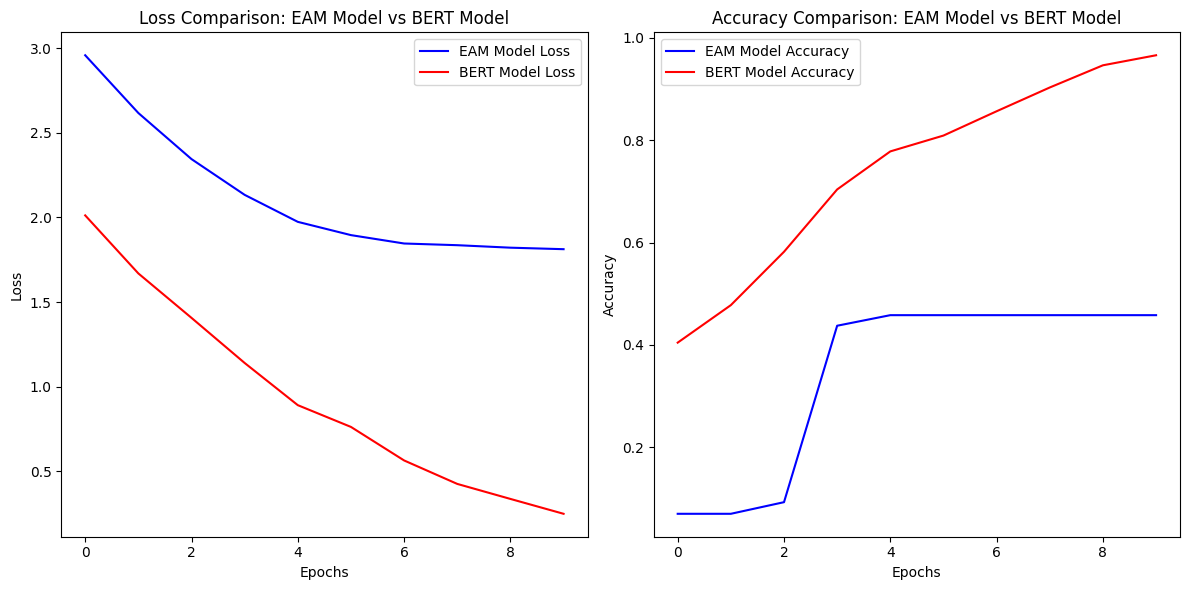

In [6]:
optimizer_eam = optim.Adam(eam_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Load the BERT tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Dataset and DataLoader for BERT
train_dataset_bert = BertIntentDataset(df, tokenizer_bert, max_len=64)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)

optimizer_bert = optim.Adam(bert_model.parameters(), lr=2e-5)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the EAM model
print("Training EAM Intent Classifier")
eam_losses, eam_accuracies = train_model(eam_model, train_loader_custom, criterion, optimizer_eam, epochs=10, device=device)

# Train the BERT model
print("Training BERT Model")
bert_losses, bert_accuracies = train_bert_model(bert_model, train_loader_bert, criterion, optimizer_bert, epochs=10, device=device)

# Plot Loss and Accuracy comparison
plt.figure(figsize=(12, 6))

# Plot Loss over Epochs for both models
plt.subplot(1, 2, 1)
plt.plot(eam_losses, label="EAM Model Loss", color="blue")
plt.plot(bert_losses, label="BERT Model Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: EAM Model vs BERT Model")
plt.legend()

# Plot Accuracy over Epochs for both models
plt.subplot(1, 2, 2)
plt.plot(eam_accuracies, label="EAM Model Accuracy", color="blue")
plt.plot(bert_accuracies, label="BERT Model Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: EAM Model vs BERT Model")
plt.legend()

plt.tight_layout()
plt.show()


Training EAM Intent Classifier with 20 Epochs


Epoch 1/50: 100%|██████████| 31/31 [00:00<00:00, 187.04it/s]


Epoch 1/50, Loss: 2.4388, Accuracy: 0.0144


Epoch 2/50: 100%|██████████| 31/31 [00:00<00:00, 192.63it/s]


Epoch 2/50, Loss: 2.1569, Accuracy: 0.3488


Epoch 3/50: 100%|██████████| 31/31 [00:00<00:00, 162.23it/s]


Epoch 3/50, Loss: 1.9947, Accuracy: 0.4582


Epoch 4/50: 100%|██████████| 31/31 [00:00<00:00, 188.37it/s]


Epoch 4/50, Loss: 1.8831, Accuracy: 0.4582


Epoch 5/50: 100%|██████████| 31/31 [00:00<00:00, 145.12it/s]


Epoch 5/50, Loss: 1.8548, Accuracy: 0.4582


Epoch 6/50: 100%|██████████| 31/31 [00:00<00:00, 181.88it/s]


Epoch 6/50, Loss: 1.8579, Accuracy: 0.4582


Epoch 7/50: 100%|██████████| 31/31 [00:00<00:00, 171.50it/s]


Epoch 7/50, Loss: 1.8333, Accuracy: 0.4582


Epoch 8/50: 100%|██████████| 31/31 [00:00<00:00, 170.12it/s]


Epoch 8/50, Loss: 1.8445, Accuracy: 0.4582


Epoch 9/50: 100%|██████████| 31/31 [00:00<00:00, 131.90it/s]


Epoch 9/50, Loss: 1.8562, Accuracy: 0.4582


Epoch 10/50: 100%|██████████| 31/31 [00:00<00:00, 166.97it/s]


Epoch 10/50, Loss: 1.8638, Accuracy: 0.4582


Epoch 11/50: 100%|██████████| 31/31 [00:00<00:00, 185.10it/s]


Epoch 11/50, Loss: 1.8425, Accuracy: 0.4582


Epoch 12/50: 100%|██████████| 31/31 [00:00<00:00, 190.29it/s]


Epoch 12/50, Loss: 1.8535, Accuracy: 0.4582


Epoch 13/50: 100%|██████████| 31/31 [00:00<00:00, 194.34it/s]


Epoch 13/50, Loss: 1.8580, Accuracy: 0.4582


Epoch 14/50: 100%|██████████| 31/31 [00:00<00:00, 174.20it/s]


Epoch 14/50, Loss: 1.8460, Accuracy: 0.4582


Epoch 15/50: 100%|██████████| 31/31 [00:00<00:00, 172.58it/s]


Epoch 15/50, Loss: 1.8393, Accuracy: 0.4582


Epoch 16/50: 100%|██████████| 31/31 [00:00<00:00, 196.12it/s]


Epoch 16/50, Loss: 1.8486, Accuracy: 0.4582


Epoch 17/50: 100%|██████████| 31/31 [00:00<00:00, 189.62it/s]


Epoch 17/50, Loss: 1.8437, Accuracy: 0.4582


Epoch 18/50: 100%|██████████| 31/31 [00:00<00:00, 194.11it/s]


Epoch 18/50, Loss: 1.8493, Accuracy: 0.4582


Epoch 19/50: 100%|██████████| 31/31 [00:00<00:00, 181.55it/s]


Epoch 19/50, Loss: 1.8465, Accuracy: 0.4582


Epoch 20/50: 100%|██████████| 31/31 [00:00<00:00, 132.49it/s]


Epoch 20/50, Loss: 1.8551, Accuracy: 0.4582


Epoch 21/50: 100%|██████████| 31/31 [00:00<00:00, 190.86it/s]


Epoch 21/50, Loss: 1.8387, Accuracy: 0.4582


Epoch 22/50: 100%|██████████| 31/31 [00:00<00:00, 198.79it/s]


Epoch 22/50, Loss: 1.8558, Accuracy: 0.4582


Epoch 23/50: 100%|██████████| 31/31 [00:00<00:00, 189.91it/s]


Epoch 23/50, Loss: 1.8245, Accuracy: 0.4582


Epoch 24/50: 100%|██████████| 31/31 [00:00<00:00, 176.82it/s]


Epoch 24/50, Loss: 1.8487, Accuracy: 0.4582


Epoch 25/50: 100%|██████████| 31/31 [00:00<00:00, 61.52it/s]


Epoch 25/50, Loss: 1.8383, Accuracy: 0.4582


Epoch 26/50: 100%|██████████| 31/31 [00:00<00:00, 122.75it/s]


Epoch 26/50, Loss: 1.8627, Accuracy: 0.4582


Epoch 27/50: 100%|██████████| 31/31 [00:00<00:00, 272.73it/s]


Epoch 27/50, Loss: 1.8521, Accuracy: 0.4582


Epoch 28/50: 100%|██████████| 31/31 [00:00<00:00, 262.06it/s]


Epoch 28/50, Loss: 1.8389, Accuracy: 0.4582


Epoch 29/50: 100%|██████████| 31/31 [00:00<00:00, 225.82it/s]


Epoch 29/50, Loss: 1.8367, Accuracy: 0.4582


Epoch 30/50: 100%|██████████| 31/31 [00:00<00:00, 229.52it/s]


Epoch 30/50, Loss: 1.8459, Accuracy: 0.4582


Epoch 31/50: 100%|██████████| 31/31 [00:00<00:00, 268.52it/s]


Epoch 31/50, Loss: 1.8494, Accuracy: 0.4582


Epoch 32/50: 100%|██████████| 31/31 [00:00<00:00, 269.60it/s]


Epoch 32/50, Loss: 1.8485, Accuracy: 0.4582


Epoch 33/50: 100%|██████████| 31/31 [00:00<00:00, 278.33it/s]


Epoch 33/50, Loss: 1.8460, Accuracy: 0.4582


Epoch 34/50: 100%|██████████| 31/31 [00:00<00:00, 277.33it/s]


Epoch 34/50, Loss: 1.8491, Accuracy: 0.4582


Epoch 35/50: 100%|██████████| 31/31 [00:00<00:00, 272.81it/s]


Epoch 35/50, Loss: 1.8570, Accuracy: 0.4582


Epoch 36/50: 100%|██████████| 31/31 [00:00<00:00, 269.18it/s]


Epoch 36/50, Loss: 1.8342, Accuracy: 0.4582


Epoch 37/50: 100%|██████████| 31/31 [00:00<00:00, 209.92it/s]


Epoch 37/50, Loss: 1.8473, Accuracy: 0.4582


Epoch 38/50: 100%|██████████| 31/31 [00:00<00:00, 216.68it/s]


Epoch 38/50, Loss: 1.8375, Accuracy: 0.4582


Epoch 39/50: 100%|██████████| 31/31 [00:00<00:00, 257.80it/s]


Epoch 39/50, Loss: 1.8482, Accuracy: 0.4582


Epoch 40/50: 100%|██████████| 31/31 [00:00<00:00, 276.95it/s]


Epoch 40/50, Loss: 1.8439, Accuracy: 0.4582


Epoch 41/50: 100%|██████████| 31/31 [00:00<00:00, 265.96it/s]


Epoch 41/50, Loss: 1.8600, Accuracy: 0.4582


Epoch 42/50: 100%|██████████| 31/31 [00:00<00:00, 280.03it/s]


Epoch 42/50, Loss: 1.8504, Accuracy: 0.4582


Epoch 43/50: 100%|██████████| 31/31 [00:00<00:00, 276.60it/s]


Epoch 43/50, Loss: 1.8498, Accuracy: 0.4582


Epoch 44/50: 100%|██████████| 31/31 [00:00<00:00, 252.74it/s]


Epoch 44/50, Loss: 1.8428, Accuracy: 0.4582


Epoch 45/50: 100%|██████████| 31/31 [00:00<00:00, 205.68it/s]


Epoch 45/50, Loss: 1.8413, Accuracy: 0.4582


Epoch 46/50: 100%|██████████| 31/31 [00:00<00:00, 226.72it/s]


Epoch 46/50, Loss: 1.8366, Accuracy: 0.4582


Epoch 47/50: 100%|██████████| 31/31 [00:00<00:00, 192.14it/s]


Epoch 47/50, Loss: 1.8455, Accuracy: 0.4582


Epoch 48/50: 100%|██████████| 31/31 [00:00<00:00, 197.03it/s]


Epoch 48/50, Loss: 1.8620, Accuracy: 0.4582


Epoch 49/50: 100%|██████████| 31/31 [00:00<00:00, 194.76it/s]


Epoch 49/50, Loss: 1.8480, Accuracy: 0.4582


Epoch 50/50: 100%|██████████| 31/31 [00:00<00:00, 211.12it/s]


Epoch 50/50, Loss: 1.8424, Accuracy: 0.4582


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT Model with 10 Epochs


Epoch 1/10: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Epoch 1/10, Loss: 1.9640, Accuracy: 0.4479


Epoch 2/10: 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Epoch 2/10, Loss: 1.6083, Accuracy: 0.5212


Epoch 3/10: 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epoch 3/10, Loss: 1.2310, Accuracy: 0.6326


Epoch 4/10: 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]


Epoch 4/10, Loss: 0.9800, Accuracy: 0.7441


Epoch 5/10: 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


Epoch 5/10, Loss: 0.7276, Accuracy: 0.8029


Epoch 6/10: 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Epoch 6/10, Loss: 0.5484, Accuracy: 0.8710


Epoch 7/10: 100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Epoch 7/10, Loss: 0.4227, Accuracy: 0.9092


Epoch 8/10: 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]


Epoch 8/10, Loss: 0.3059, Accuracy: 0.9443


Epoch 9/10: 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Epoch 9/10, Loss: 0.2244, Accuracy: 0.9732


Epoch 10/10: 100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epoch 10/10, Loss: 0.1691, Accuracy: 0.9814


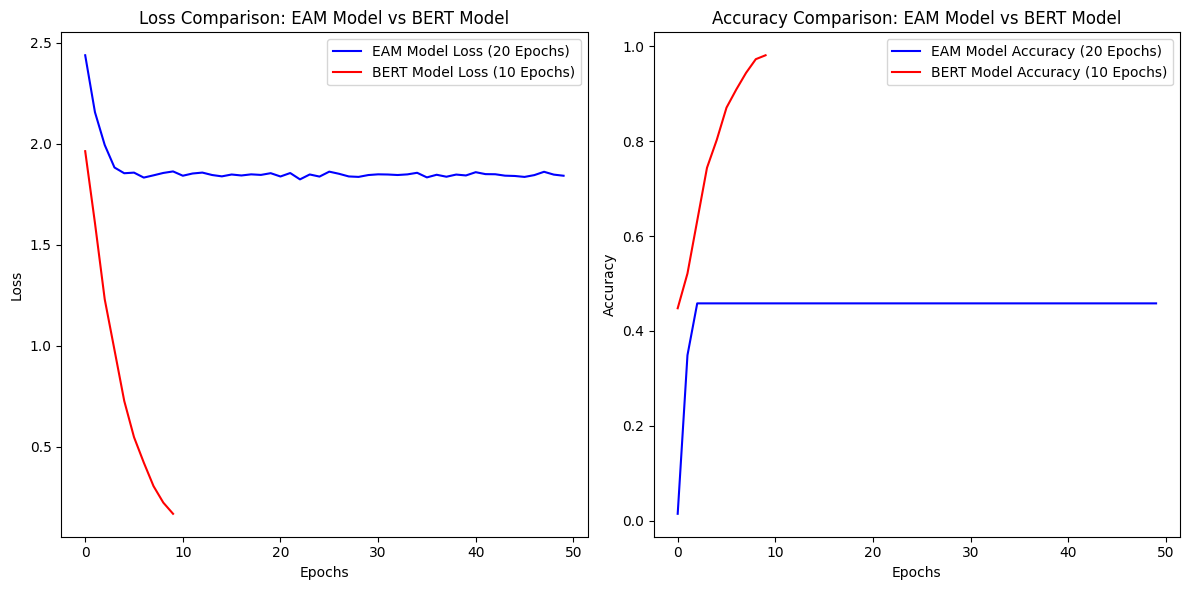

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

# Custom tokenizer function to split text into words
def custom_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Dataset preparation using the custom tokenizer
class CustomIntentDataset(Dataset):
    def __init__(self, df, vocab, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.vocab = vocab
        self.max_len = max_len

        # Map categories to numerical labels
        self.label_mapping = {label: idx for idx, label in enumerate(df['Category'].unique())}
        self.df['Category'] = self.df['Category'].map(self.label_mapping)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.df['Category'].iloc[idx]

        # Tokenize text
        tokens = custom_tokenizer(text)
        token_ids = [self.vocab.get(token, 0) for token in tokens]

        # Apply padding or truncation
        if len(token_ids) < self.max_len:
            token_ids = token_ids + [self.vocab['<PAD>']] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# Custom Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Training function for the EAM model with gradient clipping and learning rate scheduling
def train_eam_model(model, dataloader, criterion, optimizer, scheduler, epochs, device, grad_clip=None):
    model.to(device)
    train_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Learning rate scheduling
        scheduler.step()

    return train_losses, all_accuracies

# Load dataset
df = pd.read_csv("/content/PROMISE_exp.csv")

# Tokenize and build vocabulary for custom model
all_tokens = []
for desc in df['Description']:
    tokens = custom_tokenizer(desc)
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token

# Dataset and DataLoader for EAMIntentClassifier
max_len = 50
train_dataset_custom = CustomIntentDataset(df, vocab, max_len)
train_loader_custom = DataLoader(train_dataset_custom, batch_size=32, shuffle=True)

# Initialize the EAM model
vocab_size = len(vocab)
embed_dim = 16
num_heads = 2
num_classes = len(df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)

# Optimizer and learning rate scheduler
optimizer_eam = optim.AdamW(eam_model.parameters(), lr=0.001)
scheduler = StepLR(optimizer_eam, step_size=5, gamma=0.1)  # Decays LR every 5 epochs
criterion = nn.CrossEntropyLoss()

# Train the EAM model with gradient clipping and scheduler
print("Training EAM Intent Classifier with 20 Epochs")
eam_losses, eam_accuracies = train_eam_model(eam_model, train_loader_custom, criterion, optimizer_eam, scheduler, epochs=50, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), grad_clip=1.0)

# Train the BERT model with 10 epochs (same as before)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Dataset and DataLoader for BERT
train_dataset_bert = BertIntentDataset(df, tokenizer_bert, max_len=64)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)

optimizer_bert = optim.AdamW(bert_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Modified training function for BERT model (as before)
print("Training BERT Model with 10 Epochs")
bert_losses, bert_accuracies = train_bert_model(bert_model, train_loader_bert, criterion, optimizer_bert, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Plot Loss and Accuracy comparison
plt.figure(figsize=(12, 6))

# Plot Loss over Epochs for both models
plt.subplot(1, 2, 1)
plt.plot(eam_losses, label="EAM Model Loss (20 Epochs)", color="blue")
plt.plot(bert_losses, label="BERT Model Loss (10 Epochs)", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: EAM Model vs BERT Model")
plt.legend()

# Plot Accuracy over Epochs for both models
plt.subplot(1, 2, 2)
plt.plot(eam_accuracies, label="EAM Model Accuracy (20 Epochs)", color="blue")
plt.plot(bert_accuracies, label="BERT Model Accuracy (10 Epochs)", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: EAM Model vs BERT Model")
plt.legend()

plt.tight_layout()
plt.show()


Training EAM Intent Classifier with 20 Epochs


Epoch 1/20: 100%|██████████| 31/31 [00:00<00:00, 96.84it/s]


Epoch 1/20, Loss: 2.6110, Accuracy: 0.0506


Epoch 2/20: 100%|██████████| 31/31 [00:00<00:00, 96.34it/s]


Epoch 2/20, Loss: 2.3184, Accuracy: 0.1878


Epoch 3/20: 100%|██████████| 31/31 [00:00<00:00, 105.94it/s]


Epoch 3/20, Loss: 2.0944, Accuracy: 0.4458


Epoch 4/20: 100%|██████████| 31/31 [00:00<00:00, 96.03it/s]


Epoch 4/20, Loss: 1.9310, Accuracy: 0.4541


Epoch 5/20: 100%|██████████| 31/31 [00:00<00:00, 111.69it/s]


Epoch 5/20, Loss: 1.8684, Accuracy: 0.4572


Epoch 6/20: 100%|██████████| 31/31 [00:00<00:00, 109.79it/s]


Epoch 6/20, Loss: 1.8420, Accuracy: 0.4582


Epoch 7/20: 100%|██████████| 31/31 [00:00<00:00, 78.97it/s]


Epoch 7/20, Loss: 1.8401, Accuracy: 0.4582


Epoch 8/20: 100%|██████████| 31/31 [00:00<00:00, 98.28it/s]


Epoch 8/20, Loss: 1.8466, Accuracy: 0.4582


Epoch 9/20: 100%|██████████| 31/31 [00:00<00:00, 91.24it/s]


Epoch 9/20, Loss: 1.8402, Accuracy: 0.4582


Epoch 10/20: 100%|██████████| 31/31 [00:00<00:00, 126.60it/s]


Epoch 10/20, Loss: 1.8408, Accuracy: 0.4582


Epoch 11/20: 100%|██████████| 31/31 [00:00<00:00, 169.93it/s]


Epoch 11/20, Loss: 1.8369, Accuracy: 0.4582


Epoch 12/20: 100%|██████████| 31/31 [00:00<00:00, 180.22it/s]


Epoch 12/20, Loss: 1.8317, Accuracy: 0.4582


Epoch 13/20: 100%|██████████| 31/31 [00:00<00:00, 161.64it/s]


Epoch 13/20, Loss: 1.8374, Accuracy: 0.4582


Epoch 14/20: 100%|██████████| 31/31 [00:00<00:00, 176.89it/s]


Epoch 14/20, Loss: 1.8300, Accuracy: 0.4582


Epoch 15/20: 100%|██████████| 31/31 [00:00<00:00, 132.26it/s]


Epoch 15/20, Loss: 1.8402, Accuracy: 0.4582


Epoch 16/20: 100%|██████████| 31/31 [00:00<00:00, 181.48it/s]


Epoch 16/20, Loss: 1.8246, Accuracy: 0.4582


Epoch 17/20: 100%|██████████| 31/31 [00:00<00:00, 179.01it/s]


Epoch 17/20, Loss: 1.8299, Accuracy: 0.4582


Epoch 18/20: 100%|██████████| 31/31 [00:00<00:00, 169.64it/s]


Epoch 18/20, Loss: 1.8449, Accuracy: 0.4582


Epoch 19/20: 100%|██████████| 31/31 [00:00<00:00, 178.34it/s]


Epoch 19/20, Loss: 1.8437, Accuracy: 0.4582


Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 137.60it/s]


Epoch 20/20, Loss: 1.8317, Accuracy: 0.4582
Total Training Time (EAM Model): 5.25 seconds


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT Model with 10 Epochs


Epoch 1/10: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Epoch 1/10, Loss: 1.9768, Accuracy: 0.4561


Epoch 2/10: 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Epoch 2/10, Loss: 1.5443, Accuracy: 0.5263


Epoch 3/10: 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Epoch 3/10, Loss: 1.1967, Accuracy: 0.6522


Epoch 4/10: 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Epoch 4/10, Loss: 0.9602, Accuracy: 0.7430


Epoch 5/10: 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Epoch 5/10, Loss: 0.7797, Accuracy: 0.7895


Epoch 6/10: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Epoch 6/10, Loss: 0.6704, Accuracy: 0.8266


Epoch 7/10: 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


Epoch 7/10, Loss: 0.5326, Accuracy: 0.8535


Epoch 8/10: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


Epoch 8/10, Loss: 0.4168, Accuracy: 0.8958


Epoch 9/10: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Epoch 9/10, Loss: 0.3278, Accuracy: 0.9329


Epoch 10/10: 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Epoch 10/10, Loss: 0.2374, Accuracy: 0.9608
Total Training Time (BERT Model): 106.46 seconds


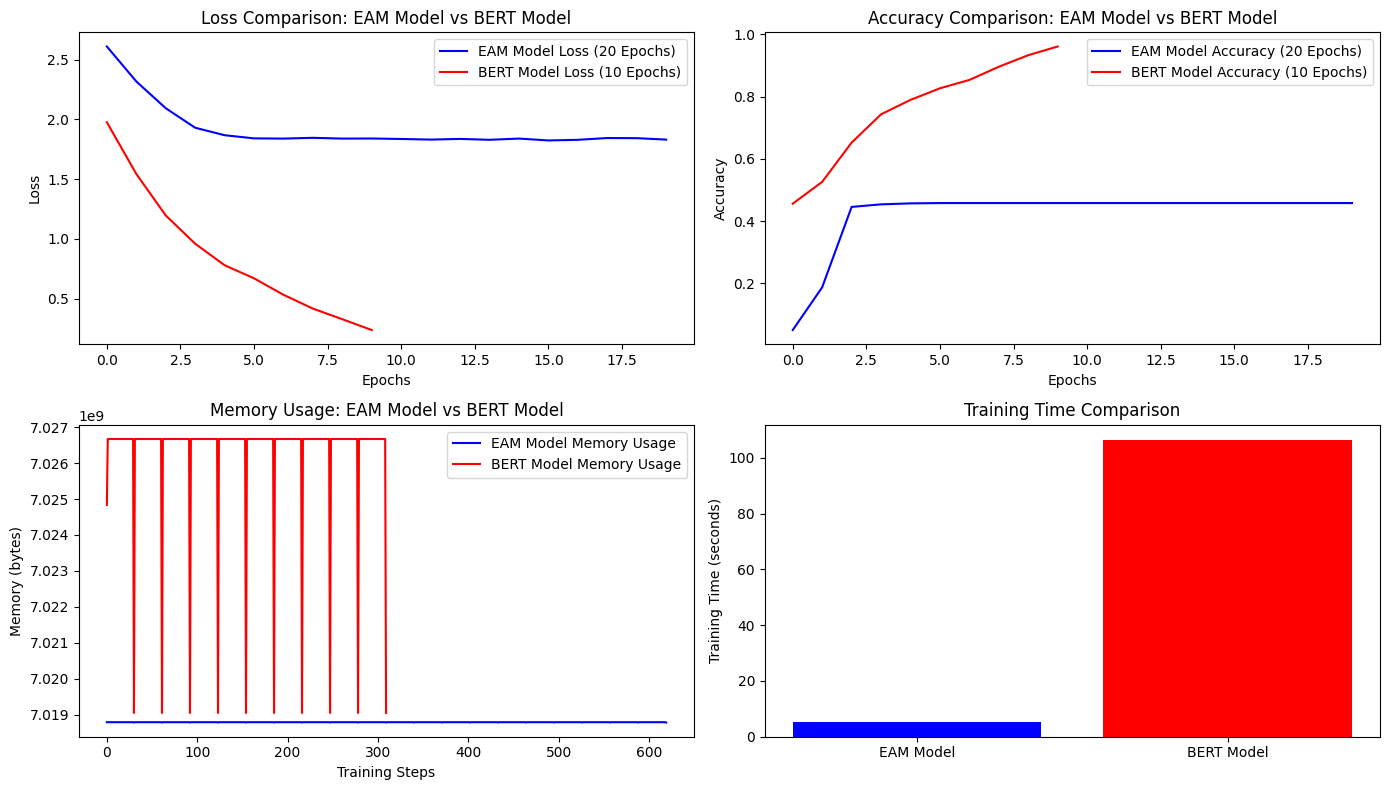

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import time

# Custom tokenizer function to split text into words
def custom_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Dataset preparation using the custom tokenizer
class CustomIntentDataset(Dataset):
    def __init__(self, df, vocab, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.vocab = vocab
        self.max_len = max_len

        # Map categories to numerical labels
        self.label_mapping = {label: idx for idx, label in enumerate(df['Category'].unique())}
        self.df['Category'] = self.df['Category'].map(self.label_mapping)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.df['Category'].iloc[idx]

        # Tokenize text
        tokens = custom_tokenizer(text)
        token_ids = [self.vocab.get(token, 0) for token in tokens]

        # Apply padding or truncation
        if len(token_ids) < self.max_len:
            token_ids = token_ids + [self.vocab['<PAD>']] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# Custom Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Training function for the EAM model with gradient clipping, memory tracking, and timing
def train_eam_model(model, dataloader, criterion, optimizer, scheduler, epochs, device, grad_clip=None):
    model.to(device)
    train_losses = []
    all_accuracies = []

    # Track memory and time
    start_time = time.time()
    total_memory = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

            # Memory tracking
            if device.type == 'cuda':
                total_memory.append(torch.cuda.memory_allocated(device))

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Learning rate scheduling
        scheduler.step()

    training_time = time.time() - start_time
    print(f"Total Training Time (EAM Model): {training_time:.2f} seconds")

    return train_losses, all_accuracies, total_memory, training_time

# Load dataset
df = pd.read_csv("/content/PROMISE_exp.csv")

# Tokenize and build vocabulary for custom model
all_tokens = []
for desc in df['Description']:
    tokens = custom_tokenizer(desc)
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token

# Dataset and DataLoader for EAMIntentClassifier
max_len = 50
train_dataset_custom = CustomIntentDataset(df, vocab, max_len)
train_loader_custom = DataLoader(train_dataset_custom, batch_size=32, shuffle=True)

# Initialize the EAM model
vocab_size = len(vocab)
embed_dim = 16
num_heads = 2
num_classes = len(df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)

# Optimizer and learning rate scheduler
optimizer_eam = optim.AdamW(eam_model.parameters(), lr=0.001)
scheduler = StepLR(optimizer_eam, step_size=5, gamma=0.1)  # Decays LR every 5 epochs
criterion = nn.CrossEntropyLoss()

# Train the EAM model with memory tracking and training time
print("Training EAM Intent Classifier with 20 Epochs")
eam_losses, eam_accuracies, eam_memory, eam_training_time = train_eam_model(eam_model, train_loader_custom, criterion, optimizer_eam, scheduler, epochs=20, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), grad_clip=1.0)

# Train the BERT model with 10 epochs and memory tracking
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Dataset and DataLoader for BERT
train_dataset_bert = BertIntentDataset(df, tokenizer_bert, max_len=64)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)

optimizer_bert = optim.AdamW(bert_model.parameters(), lr=2e-5)

# Modified training function for BERT model (with memory tracking and timing)
def train_bert_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []

    # Track memory and time
    start_time = time.time()
    total_memory = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            texts_batch, attention_mask_batch = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)
            optimizer.zero_grad()

            # Get model outputs (logits from the SequenceClassifierOutput)
            outputs = model(texts_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits  # Extract logits for loss calculation
            loss = criterion(logits, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

            # Memory tracking

            # Memory tracking
            if device.type == 'cuda':
                total_memory.append(torch.cuda.memory_allocated(device))

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    training_time = time.time() - start_time
    print(f"Total Training Time (BERT Model): {training_time:.2f} seconds")

    return train_losses, all_accuracies, total_memory, training_time

# Train the BERT model with memory tracking and training time
print("Training BERT Model with 10 Epochs")
bert_losses, bert_accuracies, bert_memory, bert_training_time = train_bert_model(bert_model, train_loader_bert, criterion, optimizer_bert, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Plot Loss, Accuracy, Memory, and Training Time comparison
plt.figure(figsize=(14, 8))

# Plot Loss over Epochs for both models
plt.subplot(2, 2, 1)
plt.plot(eam_losses, label="EAM Model Loss (20 Epochs)", color="blue")
plt.plot(bert_losses, label="BERT Model Loss (10 Epochs)", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: EAM Model vs BERT Model")
plt.legend()

# Plot Accuracy over Epochs for both models
plt.subplot(2, 2, 2)
plt.plot(eam_accuracies, label="EAM Model Accuracy (20 Epochs)", color="blue")
plt.plot(bert_accuracies, label="BERT Model Accuracy (10 Epochs)", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: EAM Model vs BERT Model")
plt.legend()

# Plot Memory Usage for both models
plt.subplot(2, 2, 3)
plt.plot(eam_memory, label="EAM Model Memory Usage", color="blue")
plt.plot(bert_memory, label="BERT Model Memory Usage", color="red")
plt.xlabel("Training Steps")
plt.ylabel("Memory (bytes)")
plt.title("Memory Usage: EAM Model vs BERT Model")
plt.legend()

# Plot Training Time for both models
plt.subplot(2, 2, 4)
plt.bar(["EAM Model", "BERT Model"], [eam_training_time, bert_training_time], color=["blue", "red"])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")

plt.tight_layout()
plt.show()
